In [1]:
%load_ext autoreload
%autoreload 2

# Vision Greedy InfoMax

In [2]:
import numpy as np
import pandas as pd
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

In [3]:
from GreedyInfoMax.vision.models import FullModel, load_vision_model
from GreedyInfoMax.vision.data import get_dataloader

In [4]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [5]:
# Read trained models
folder = 'logs/domain_test'
model_num = 0

In [6]:
class Opt(object):
    pass
opt = Opt()
opt.negative_samples = 12
opt.model_splits = 3
opt.loss = 0
opt.resnet = 50
opt.grayscale = False
opt.prediction_step = 5
opt.train_module = 3
opt.weight_init = False
opt.learning_rate = 2e-4
opt.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt.batch_size = 5
opt.model_type = 0
opt.model_path = folder
opt.model_num = model_num
opt.experiment = 'vision'
opt.data_input_dir = 'E:/data/camelyon_tumor_20x'
opt.batch_size_multiGPU = 1
opt.validate = False
opt.domain_loss = False

In [7]:
model, optimizer = load_vision_model.load_model_and_optimizer(opt, reload_model=True, calc_loss=False)

Contrasting against  12  negative samples
ModuleList(
  (0): ModuleList(
    (0): ResNet_Encoder(
      (model): Sequential(
        (Conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (layer 0): Sequential(
          (0): PreActBottleneckNoBN(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
            (shortcut): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
            )
          )
          (1): PreActBottleneckNoBN(
            (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): PreActBottleneckNoBN(
            (conv1): Conv2d(256, 64, kernel_si

In [8]:
_,_, _,_,test_loader,test_dataset = get_dataloader.get_camelyon_dataloader(opt)

reading E:/data/camelyon_tumor_20x/camelyon17_patches_w_center.csv file


e:\.venvs\greedy_infomax-eqyl1qxu\lib\site-packages\IPython\core\interactiveshell.py:3242: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Removing non-existing file from dataset: 85f697bba7f8a3b9ac71bf39d767ea0ae67c986227d106c4210cd8ecc36dffe8.jpg
Removing non-existing file from dataset: 9480de90f424fbd46cb764be9957702cfaba6e5008f95f6a9d4a399173cb571d.jpg
train / valid / total
35 / 15 / 50
training patches:  label
NONTUMOR    87555
TUMOR       51395
dtype: int64
validation patches:  label
NONTUMOR    37475
TUMOR       24363
dtype: int64
Use (train+val) / test split


In [9]:
model.eval()
total_step = len(test_loader)

outputs = []
labels = []
patch_ids = []

avg_pool = nn.AvgPool2d((7, 7), stride=0, padding=0)
for step, (img, label) in enumerate(test_loader):
    print('\r {}/{}'.format(step, total_step), end="")
    model_input = img.to(opt.device)
    label = label.to(opt.device)

    _, _, h, _ = model(model_input, label, n=opt.train_module)
    output = avg_pool(h).squeeze().detach().cpu().numpy()
    outputs.extend(output)
    labels.extend(label.detach().cpu().numpy())
#     patch_ids.extend(patch_id)
    
#     loss = torch.mean(loss, 0)

#     loss_epoch += loss.data.cpu().numpy()


 5789/12368

KeyboardInterrupt: 

In [10]:
len(outputs)

28945

In [11]:
out_array = np.stack(outputs[:5000])

In [12]:
labels_array = np.asarray(labels[:5000])

In [13]:
labels_array.shape

(5000,)

In [82]:
np.save('outputs.npy', out_array)

In [83]:
np.save('labels.npy', labels_array)

In [84]:
np.save('patch_ids.npy', patch_ids[:5000])

In [11]:
out_array = np.load('outputs.npy')
labels_array = np.load('labels.npy')
patch_ids = np.load('patch_ids.npy')


# UMAP outputs

In [14]:
reducer = umap.UMAP()

In [15]:
embedding = reducer.fit_transform(out_array[:4000])
embedding.shape

(4000, 2)

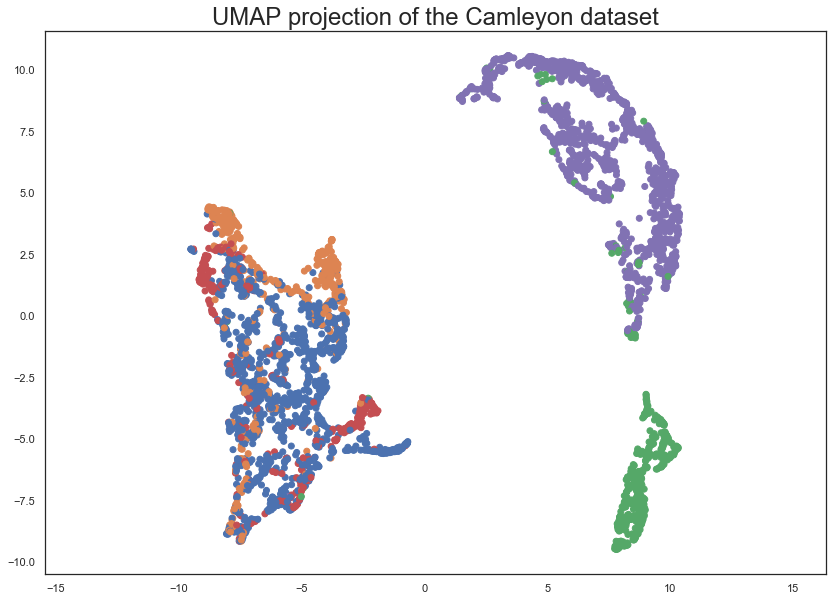

In [17]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in labels_array[:4000]])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Camleyon dataset', fontsize=24);

In [18]:
images = []
for patch_id, label in zip(patch_ids[:4000], labels[:4000]):
#     path = f'/mnt/data/site_normalized/validation_norm/camelyon17_imagedata/{row.patch_id}.png'
    path = f'E:/data/camelyon_tumor_20x/camelyon17_imagedata/{patch_id}.jpg'
    img = np.asarray(Image.open(path).resize((32, 32)))   
    images.append({"img": img, "label": label})

In [19]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.spatial import ConvexHull
# Plot with images

def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)

def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1, save=False):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []

    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i['img'], zoom=image_zoom)
        ab = AnnotationBbox(img, 
                            (x0, y0), 
                            xycoords='data', 
                            frameon=False, 
#                             pad=0.2,
#                             bboxprops=dict(edgecolor=tab10_cmap[i['label']], linewidth=3)
                           )
        artists.append(ax.add_artist(ab))
 
    
    alpha = 0.1
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    if save:
        plt.savefig(f'./tsne_img.jpg', format='jpg', dpi=600)
    plt.show()


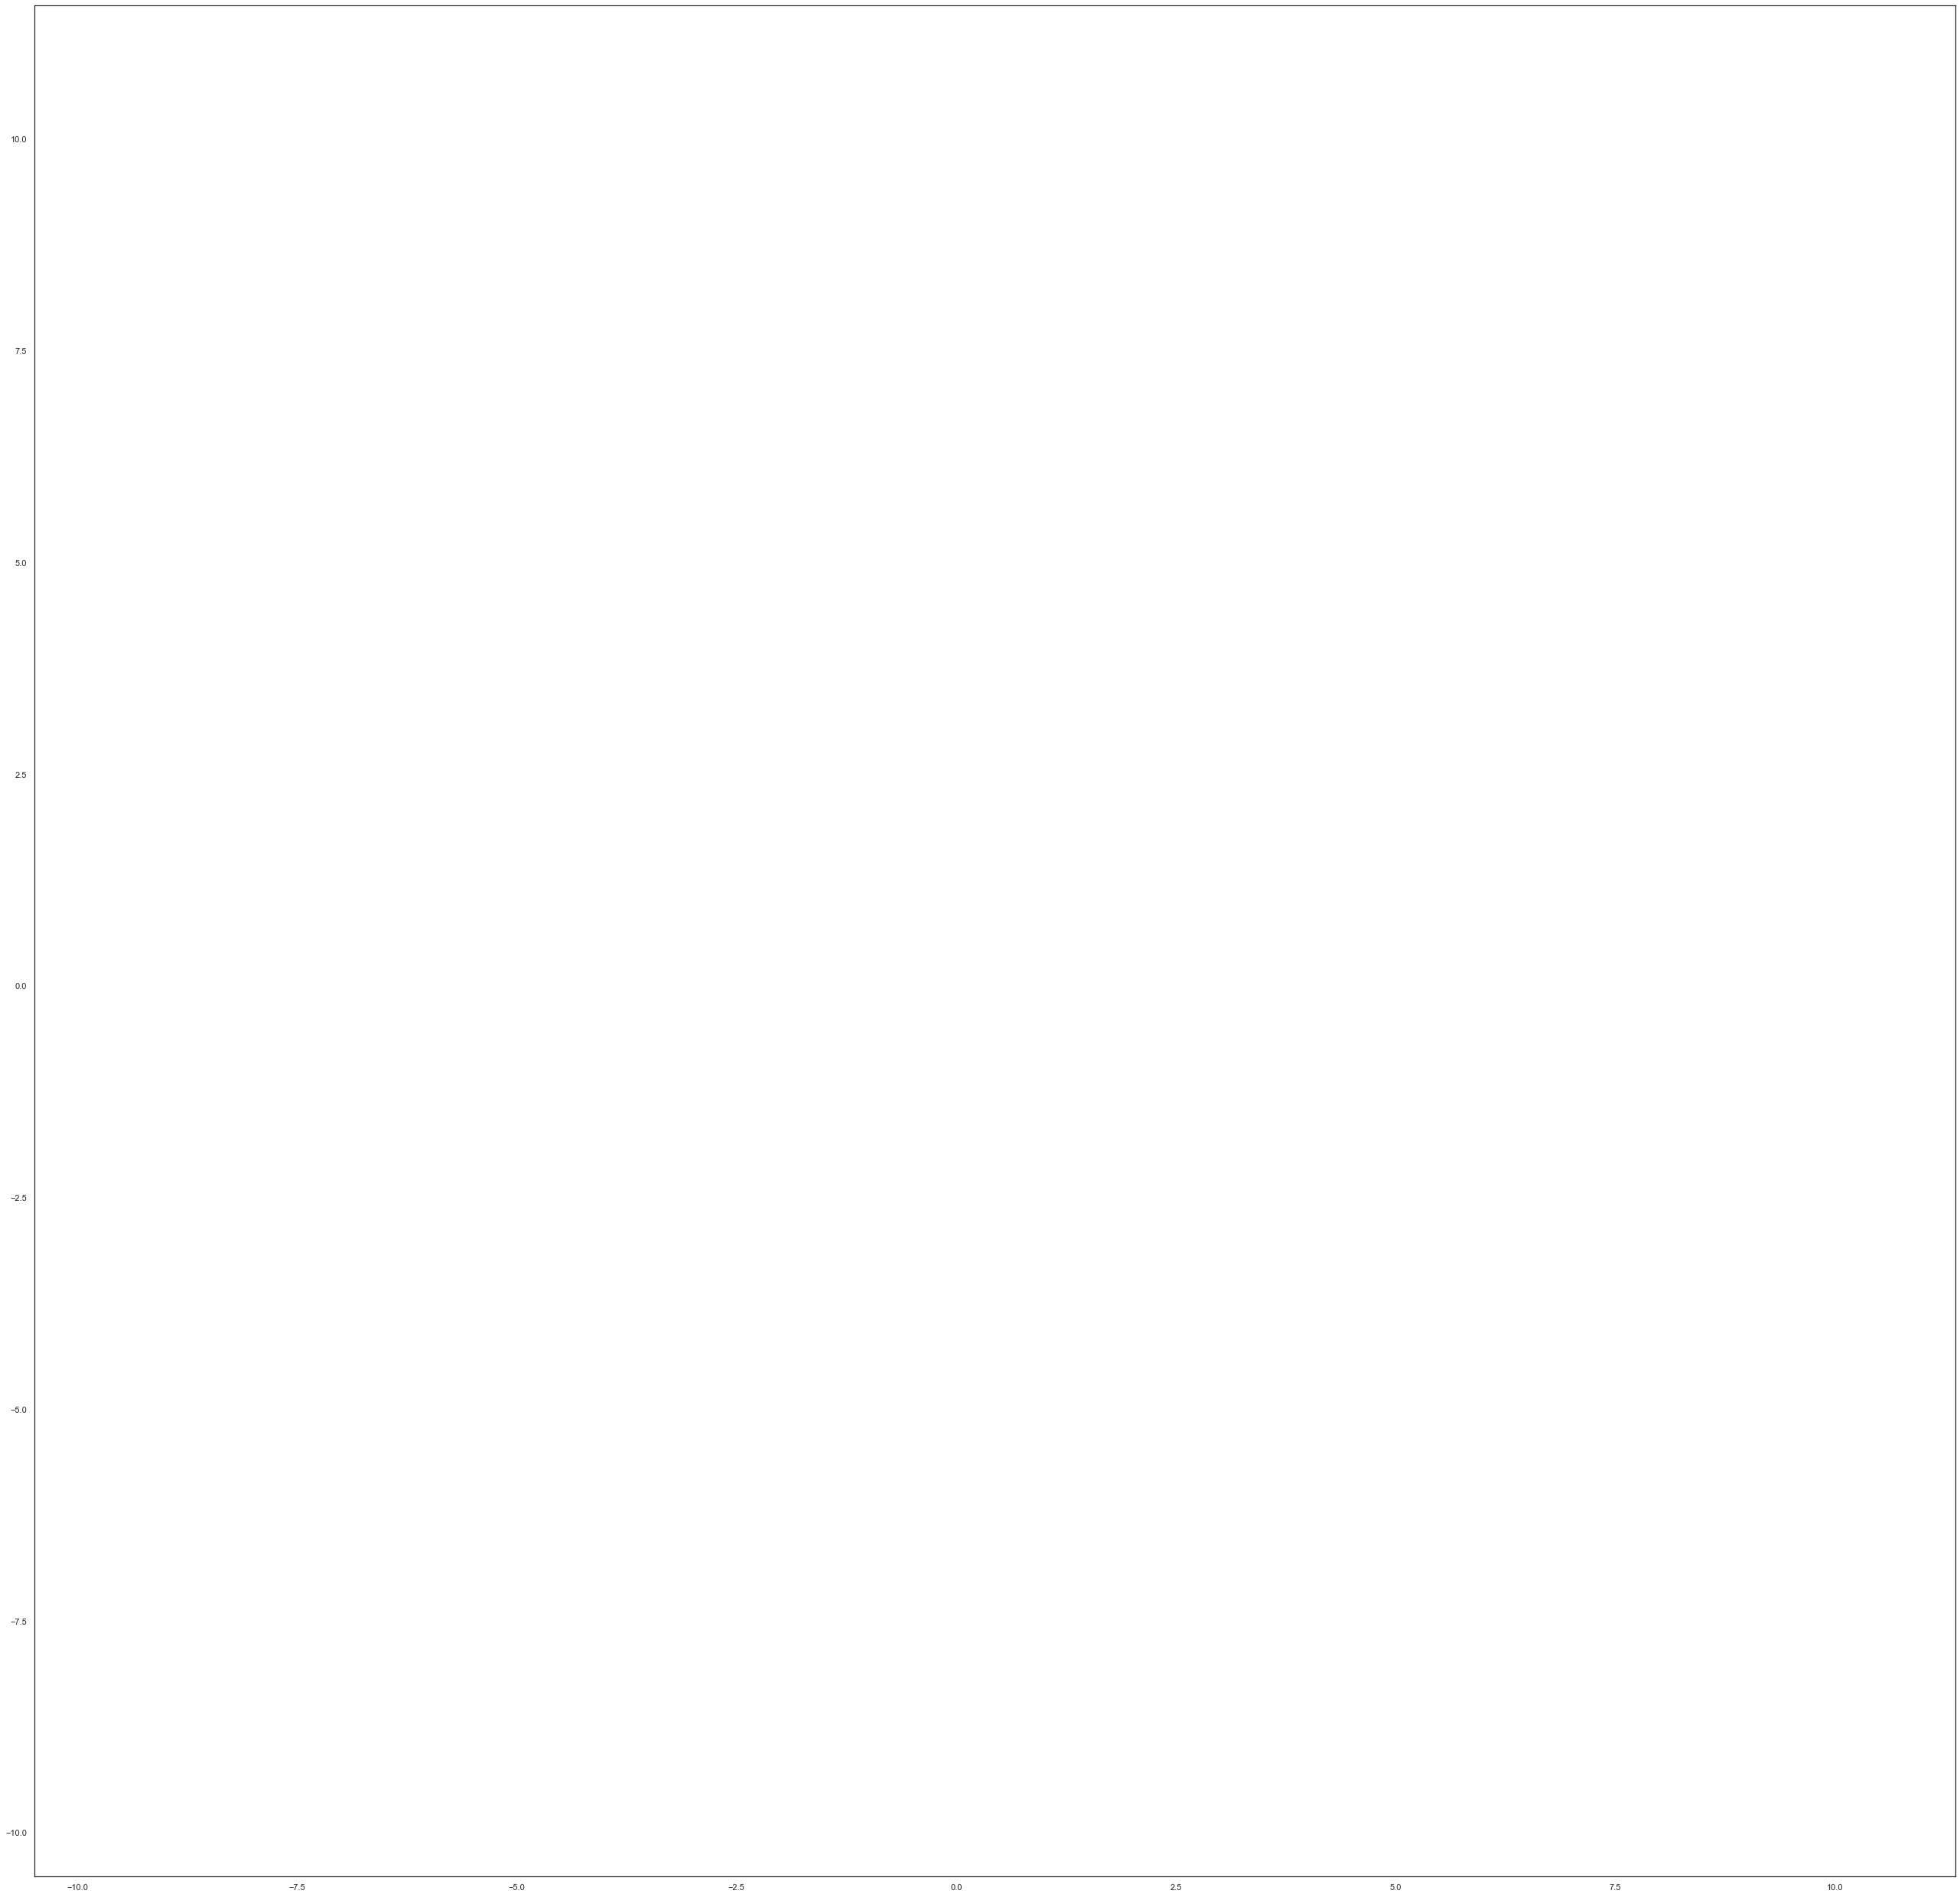

In [20]:
visualize_scatter_with_images(embedding, images, save=False)

In [53]:
df = pd.read_csv('E:/data/camelyon_tumor_20x/camelyon17_patches.csv')
slide_mapping = pd.read_csv('E:/data/tumor_data/slide_mapping_to_center.csv')

e:\.venvs\greedy_infomax-eqyl1qxu\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
def add_center(slide_id):
    center = slide_mapping[slide_mapping.slide_id == slide_id].center
    return int(center)

In [55]:
df['center'] = df.slide_id.map(add_center)

In [59]:
df.center.unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [60]:
centers = [int(list(df[df.patch_id == patch_id].center)[0]) for patch_id in patch_ids[:4000]]

In [73]:
df_d = pd.DataFrame({'x': embedding[:,0], 'y': embedding[:,1], 'center': centers, 'label': labels_array[:4000]})

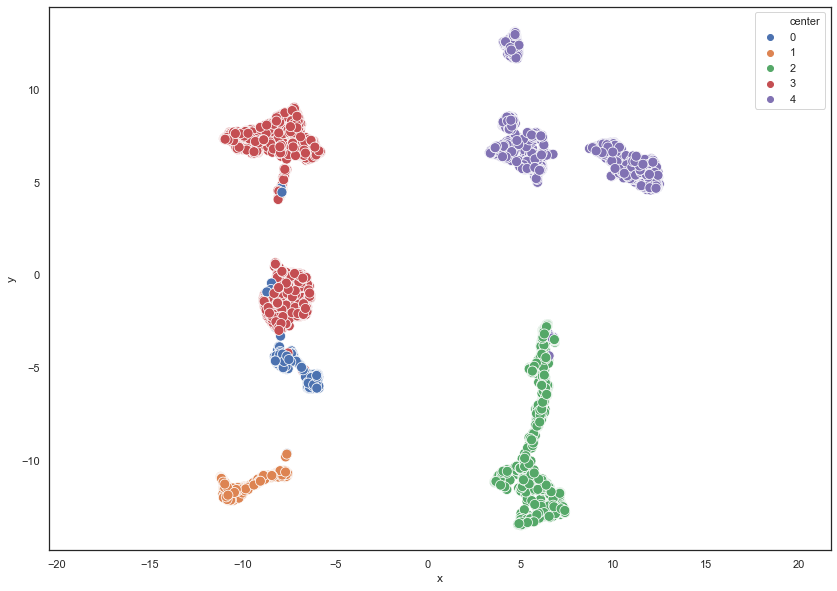

In [39]:

sns.scatterplot(x='x', y='y', hue='center', data=df_d, palette=sns.color_palette("deep", 5), s=100)
g = plt.gca().set_aspect('equal', 'datalim')


# plt.title('UMAP projection of the Camleyon dataset', fontsize=24);

In [5]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)

In [12]:
clust.fit(out_array[:4000])


OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30,
       max_eps=inf, metric='minkowski', metric_params=None,
       min_cluster_size=0.05, min_samples=50, n_jobs=None, p=2,
       predecessor_correction=True, xi=0.05)

In [27]:
labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=1.2)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=2)

space = np.arange(len(out_array[:4000]))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

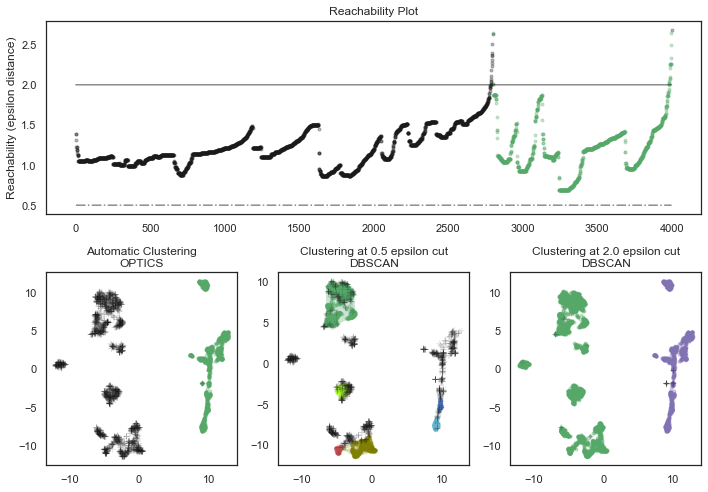

In [28]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = embedding[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(embedding[clust.labels_ == -1, 0], embedding[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

# DBSCAN at 0.5
colors = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
for klass, color in zip(range(0, 6), colors):
    Xk = embedding[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker='.')
ax3.plot(embedding[labels_050 == -1, 0], embedding[labels_050 == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Clustering at 0.5 epsilon cut\nDBSCAN')

# DBSCAN at 2.
colors = ['g.', 'm.', 'y.', 'c.']
for klass, color in zip(range(0, 4), colors):
    Xk = embedding[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(embedding[labels_200 == -1, 0], embedding[labels_200 == -1, 1], 'k+', alpha=0.1)
ax4.set_title('Clustering at 2.0 epsilon cut\nDBSCAN')

plt.tight_layout()
plt.show()

In [75]:
by_label = list(df_d.sort_values('label').index)

In [36]:
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(out_array[:4000], n_neighbors=20, include_self=False)

In [70]:
connectivity_sorted = connectivity.toarray()[np.ix_(by_center, by_center)]

In [76]:
connectivity_sort_label = connectivity.toarray()[np.ix_(by_label, by_label)]

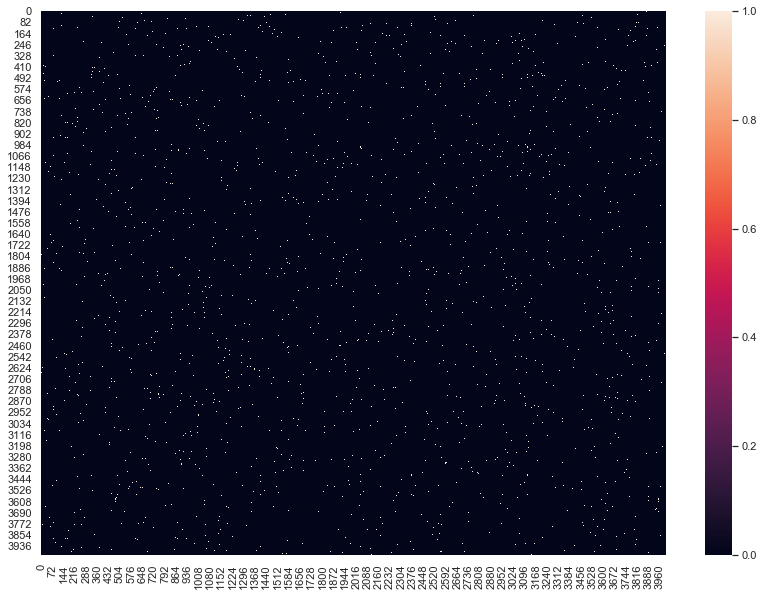

In [50]:
sns.heatmap(connectivity.toarray())

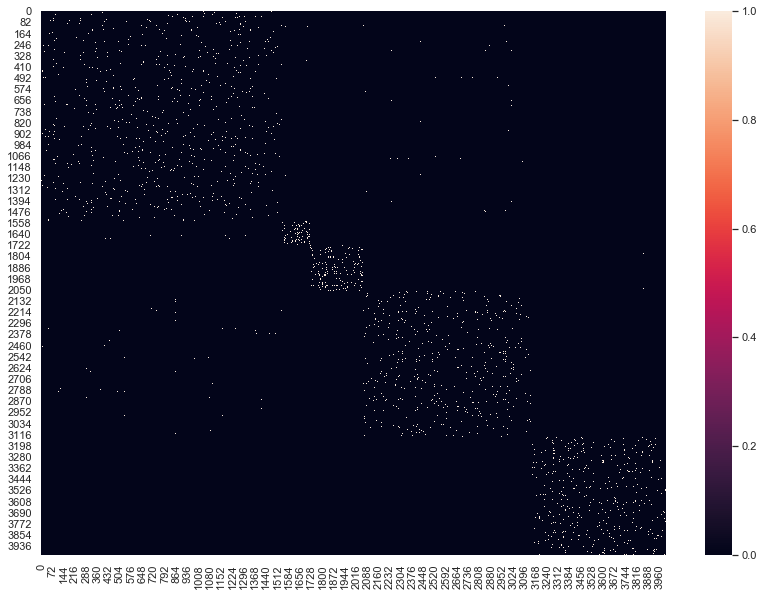

In [72]:
sns.heatmap(connectivity_sorted)

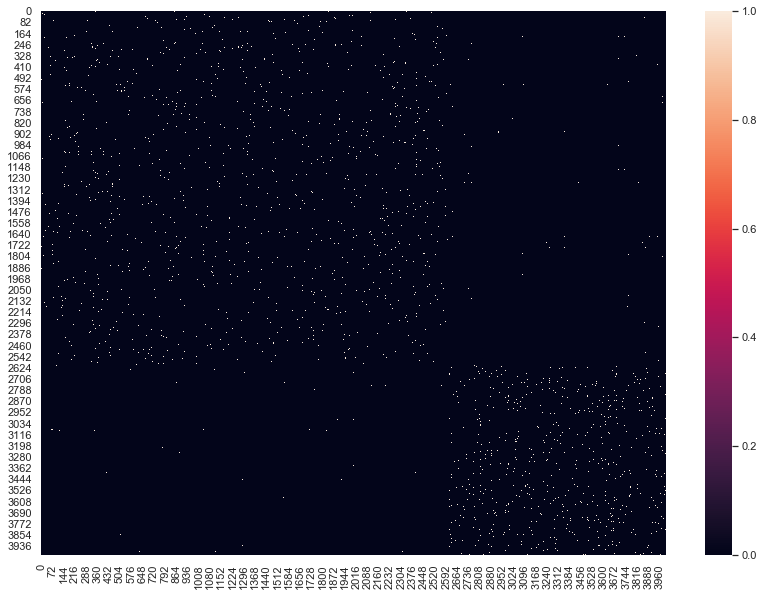

In [77]:
sns.heatmap(connectivity_sort_label)

In [78]:
from sklearn.cluster import AgglomerativeClustering
ward = AgglomerativeClustering(n_clusters=2, connectivity=connectivity,
                               linkage='ward').fit(out_array[:4000])
label = ward.labels_

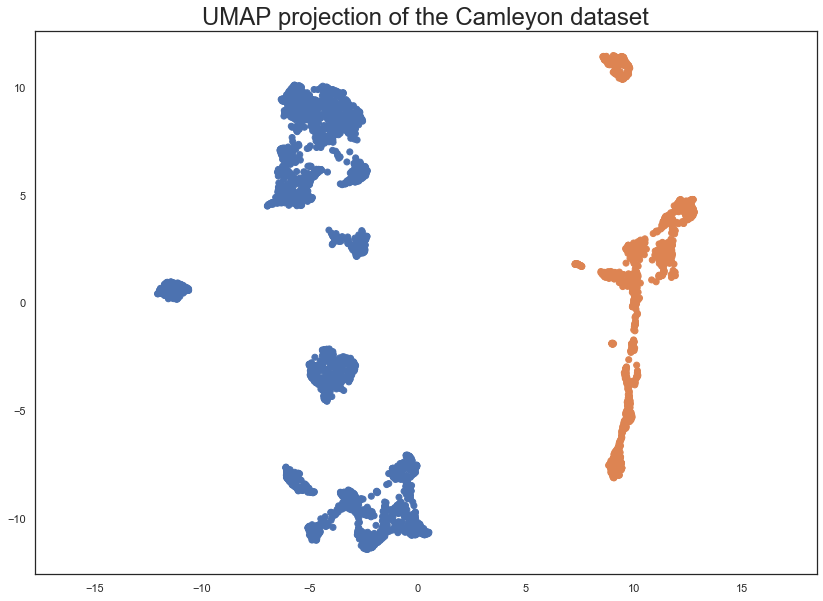

In [79]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in label[:4000]])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Camleyon dataset', fontsize=24);

In [80]:
from sklearn.neighbors import NearestNeighbors

In [112]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(out_array[:12000])

In [113]:
distances, indices = nbrs.kneighbors(out_array[:12000])

In [118]:
ms = np.argsort(np.mean(distances, axis=1))

In [132]:
ms[:5]

array([  10, 4382, 2548, 2011, 2491], dtype=int64)

In [119]:
# Points with neighbours farthest away
print(distances[ms[0],:])
print(distances[ms[1],:])
print(distances[ms[2],:])

[0.         0.14296637 0.25625192 0.28683282 0.29033215 0.33285918
 0.40323184 0.47269606 0.68188289 0.70234102]
[0.         0.14296637 0.23387754 0.24795392 0.2624997  0.29706449
 0.45122309 0.4705545  0.71966525 0.76090082]
[0.         0.21355793 0.22021265 0.25625192 0.2624997  0.29593501
 0.4696809  0.59667708 0.63220628 0.67239922]


In [120]:
# Points with closest neighbours
print(distances[ms[-1],:])
print(distances[ms[-2],:])
print(distances[ms[-3],:])

[0.         1.0793982  1.87785667 2.63100103 2.67206414 3.41649666
 3.48800677 3.52649571 3.55535106 3.56662006]
[0.         2.42222207 2.4645183  2.50467136 2.51275346 2.60138047
 2.61746615 2.72196592 2.72492628 2.7279826 ]
[0.         1.72895989 2.0566648  2.36230019 2.51381306 2.7742707
 2.79640097 2.81499343 2.84085154 2.88024585]


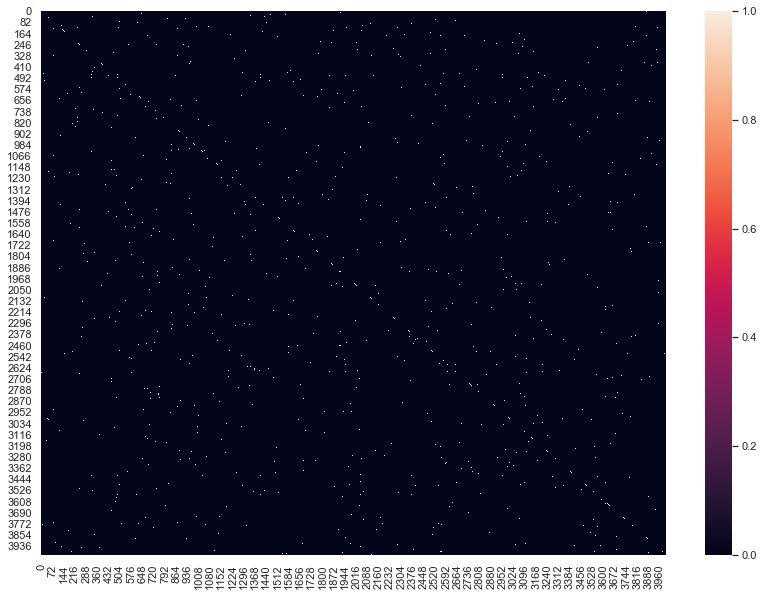

In [87]:
sns.heatmap(nbrs.kneighbors_graph(out_array[:4000]).toarray())

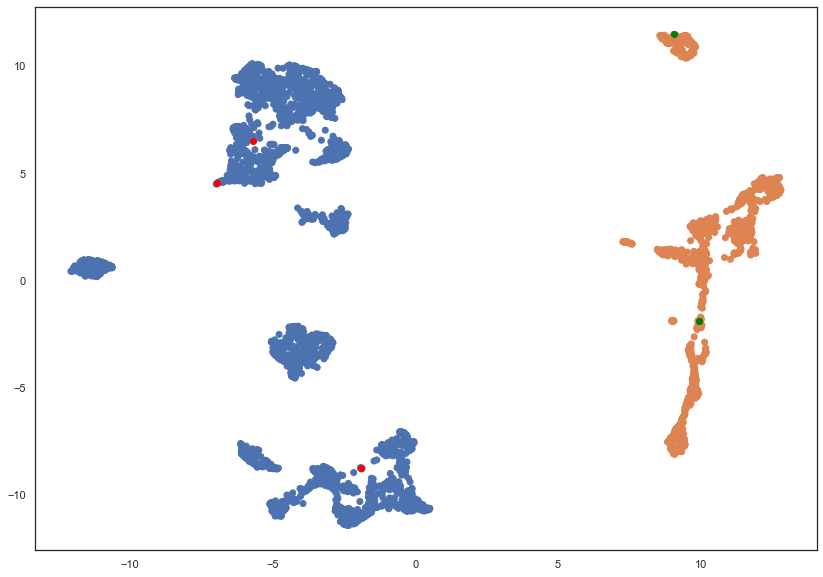

In [135]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in label[:4000]])
plt.scatter(embedding[[549, 2008, 3864], 0], embedding[[549, 2008, 3864], 1], c='red')
plt.scatter(embedding[[2548, 2011, 2491], 0], embedding[[2548, 2011, 2491], 1], c='green')

# Colon data (out of distribution)

In [15]:
df_colon = pd.read_csv('E:/data/colon/exp_1911apka/colon_patches.csv').reset_index().set_index('filename')

e:\.venvs\greedy_infomax-eqyl1qxu\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
df_colon.head()

,index,Unnamed: 0,seriesInstanceUid,label,request_id,slide_id,block,stain,resolution,scanPower,width,height,source,is_primtumor,annot_id,srctype,is_validation,position_x,position_y,center
filename,,,,,,,,,,,,,,,,,,,,
roi_lgl_norm/0.jpg,0,0,10104,roi_lgl_norm,AIDA-CR1-A-000001,10104.0,K,HE;11,0.4944,20.0,59759.0,29349.0,lkpg,False,10345,Area,False,0.124381,0.043848,1
roi_lgl_norm/1.jpg,1,1,10104,roi_lgl_norm,AIDA-CR1-A-000001,10104.0,K,HE;11,0.4944,20.0,59759.0,29349.0,lkpg,False,10345,Area,False,0.133622,0.043848,1
roi_lgl_norm/2.jpg,2,2,10104,roi_lgl_norm,AIDA-CR1-A-000001,10104.0,K,HE;11,0.4944,20.0,59759.0,29349.0,lkpg,False,10345,Area,False,0.142862,0.043848,1
roi_lgl_norm/3.jpg,3,3,10104,roi_lgl_norm,AIDA-CR1-A-000001,10104.0,K,HE;11,0.4944,20.0,59759.0,29349.0,lkpg,False,10345,Area,False,0.152102,0.043848,1
roi_lgl_norm/4.jpg,4,4,10104,roi_lgl_norm,AIDA-CR1-A-000001,10104.0,K,HE;11,0.4944,20.0,59759.0,29349.0,lkpg,False,10345,Area,False,0.161342,0.043848,1


In [17]:
opt_colon = Opt()
opt_colon.negative_samples = 12
opt_colon.model_splits = 3
opt_colon.loss = 0
opt_colon.resnet = 50
opt_colon.grayscale = False
opt_colon.prediction_step = 5
opt_colon.train_module = 3
opt_colon.weight_init = False
opt_colon.learning_rate = 2e-4
opt_colon.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt_colon.batch_size = 5
opt_colon.model_type = 0
opt_colon.model_path = folder
opt_colon.model_num = 12
opt_colon.experiment = 'vision'
opt_colon.batch_size_multiGPU = 1
opt_colon.validate = False
opt_colon.data_input_dir = 'E:/data/colon/exp_1911apka'

In [20]:
_,_, _,_,colon_test_loader,colon_test_dataset = get_dataloader.get_lnco_dataloader(opt_colon)

reading csv file


e:\.venvs\greedy_infomax-eqyl1qxu\lib\site-packages\IPython\core\interactiveshell.py:3242: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Removing non-existing file from dataset: roi_lgl_norm/8310.jpgTotal number of images dropped:  40
train / valid / total
26 / 12 / 38
training patches:  label
roi_lgl_norm    79543
tumor           99735
dtype: int64
validation patches:  label
roi_lgl_norm    69997
tumor           28488
dtype: int64
Use (train+val) / test split


In [44]:
#df_cam17 = pd.read_csv('E:/data/camelyon_tumor_20x/camelyon17_patches.csv')

In [23]:
model.eval()
total_step = len(colon_test_loader)

outputs = []
labels = []
patch_ids = []

avg_pool = nn.AvgPool2d((7, 7), stride=0, padding=0)
for step, (img, label, patch_id) in enumerate(colon_test_loader):
    print('\r {}/{}'.format(step, total_step), end="")
    model_input = img.to(opt.device)
    label = label.to(opt.device)

    _, _, h, _ = model(model_input, label, n=opt.train_module)
    output = avg_pool(h).squeeze().detach().cpu().numpy()
    outputs.append(output)
    labels.extend(label.detach().cpu().numpy())
    patch_ids.extend(patch_id)
    
    if step >= 1000:
        break
#     loss = torch.mean(loss, 0)

#     loss_epoch += loss.data.cpu().numpy()


 1000/98485

In [24]:
len(outputs)

1001

In [25]:
out_array_colon = np.stack(outputs[:1000])

In [27]:
out_array_colon.shape

(1000, 1024)

In [28]:
labels_array_colon = np.asarray(labels[:1000])

In [29]:
labels_array_colon.shape

(1000,)

In [30]:
np.save('outputs_colon.npy', out_array_colon)

In [31]:
np.save('labels_colon.npy', labels_array_colon)

In [32]:
np.save('patch_ids_colon.npy', patch_ids)

In [93]:
common_array = np.concatenate((out_array[:4000], out_array_colon), axis=0)

In [94]:
common_labels_array = np.concatenate((labels_array[:4000], labels_array_colon), axis=0)

In [95]:
common_array.shape

(5000, 1024)

In [96]:
reducer = umap.UMAP()

In [97]:
embedding = reducer.fit_transform(common_array)
embedding.shape

e:\.venvs\greedy_infomax-eqyl1qxu\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\.venvs\greedy_infomax-eqyl1qxu\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


(5000, 2)

In [98]:
dataset_array = np.ones((5000,), dtype=np.uint8)

In [99]:
dataset_array[:4000] = 0

In [2]:
dataset_array

NameError: name 'dataset_array' is not defined

In [101]:
df_common = pd.DataFrame({'x': embedding[:, 0], 'y': embedding[:, 1], 'label': common_labels_array, 'dataset': dataset_array})

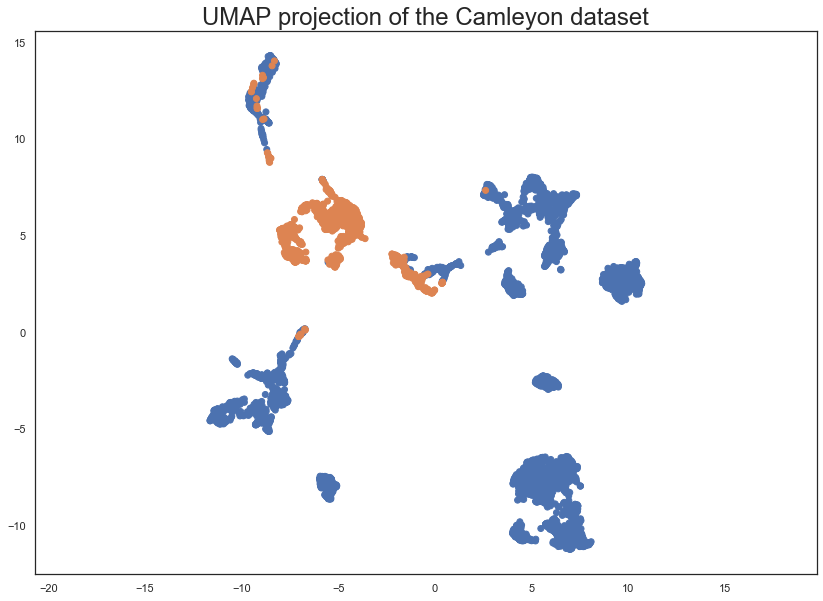

In [102]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in dataset_array], )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Camleyon dataset', fontsize=24);

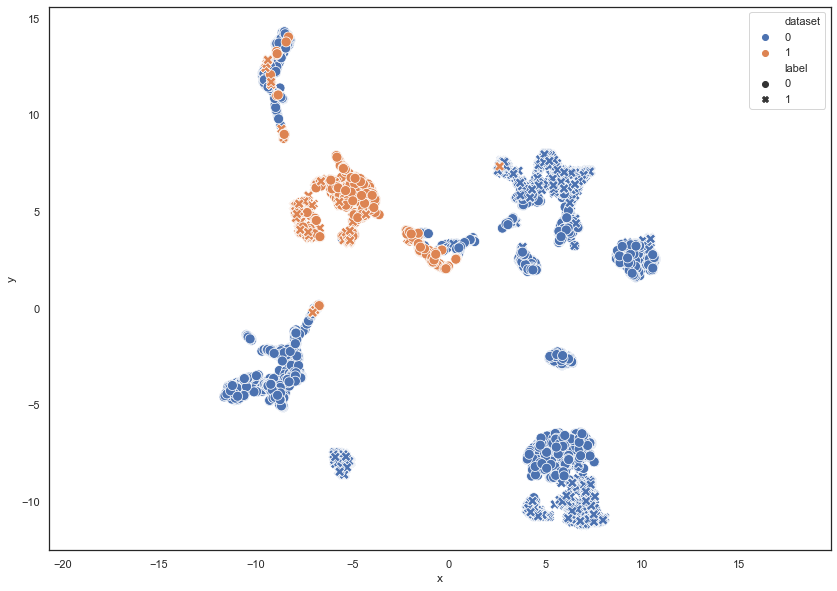

In [107]:
sns.scatterplot(x='x', y='y', style='label', hue='dataset', data=df_common, palette=sns.color_palette("deep", 2), s=100)
g = plt.gca().set_aspect('equal', 'datalim')

In [70]:
images_colon = []
for patch_id, label in zip(patch_ids, labels_array_colon):
#     path = f'/mnt/data/site_normalized/validation_norm/camelyon17_imagedata/{row.patch_id}.png'
    path = f'E:/data/colon/exp_1911apka/colon_imagedata/{patch_id}.jpg'
    img = np.asarray(Image.open(path).resize((32, 32)))   
    images_colon.append({"img": img, "label": label})

In [92]:
images_common = np.concatenate((images, images_colon), axis=0)

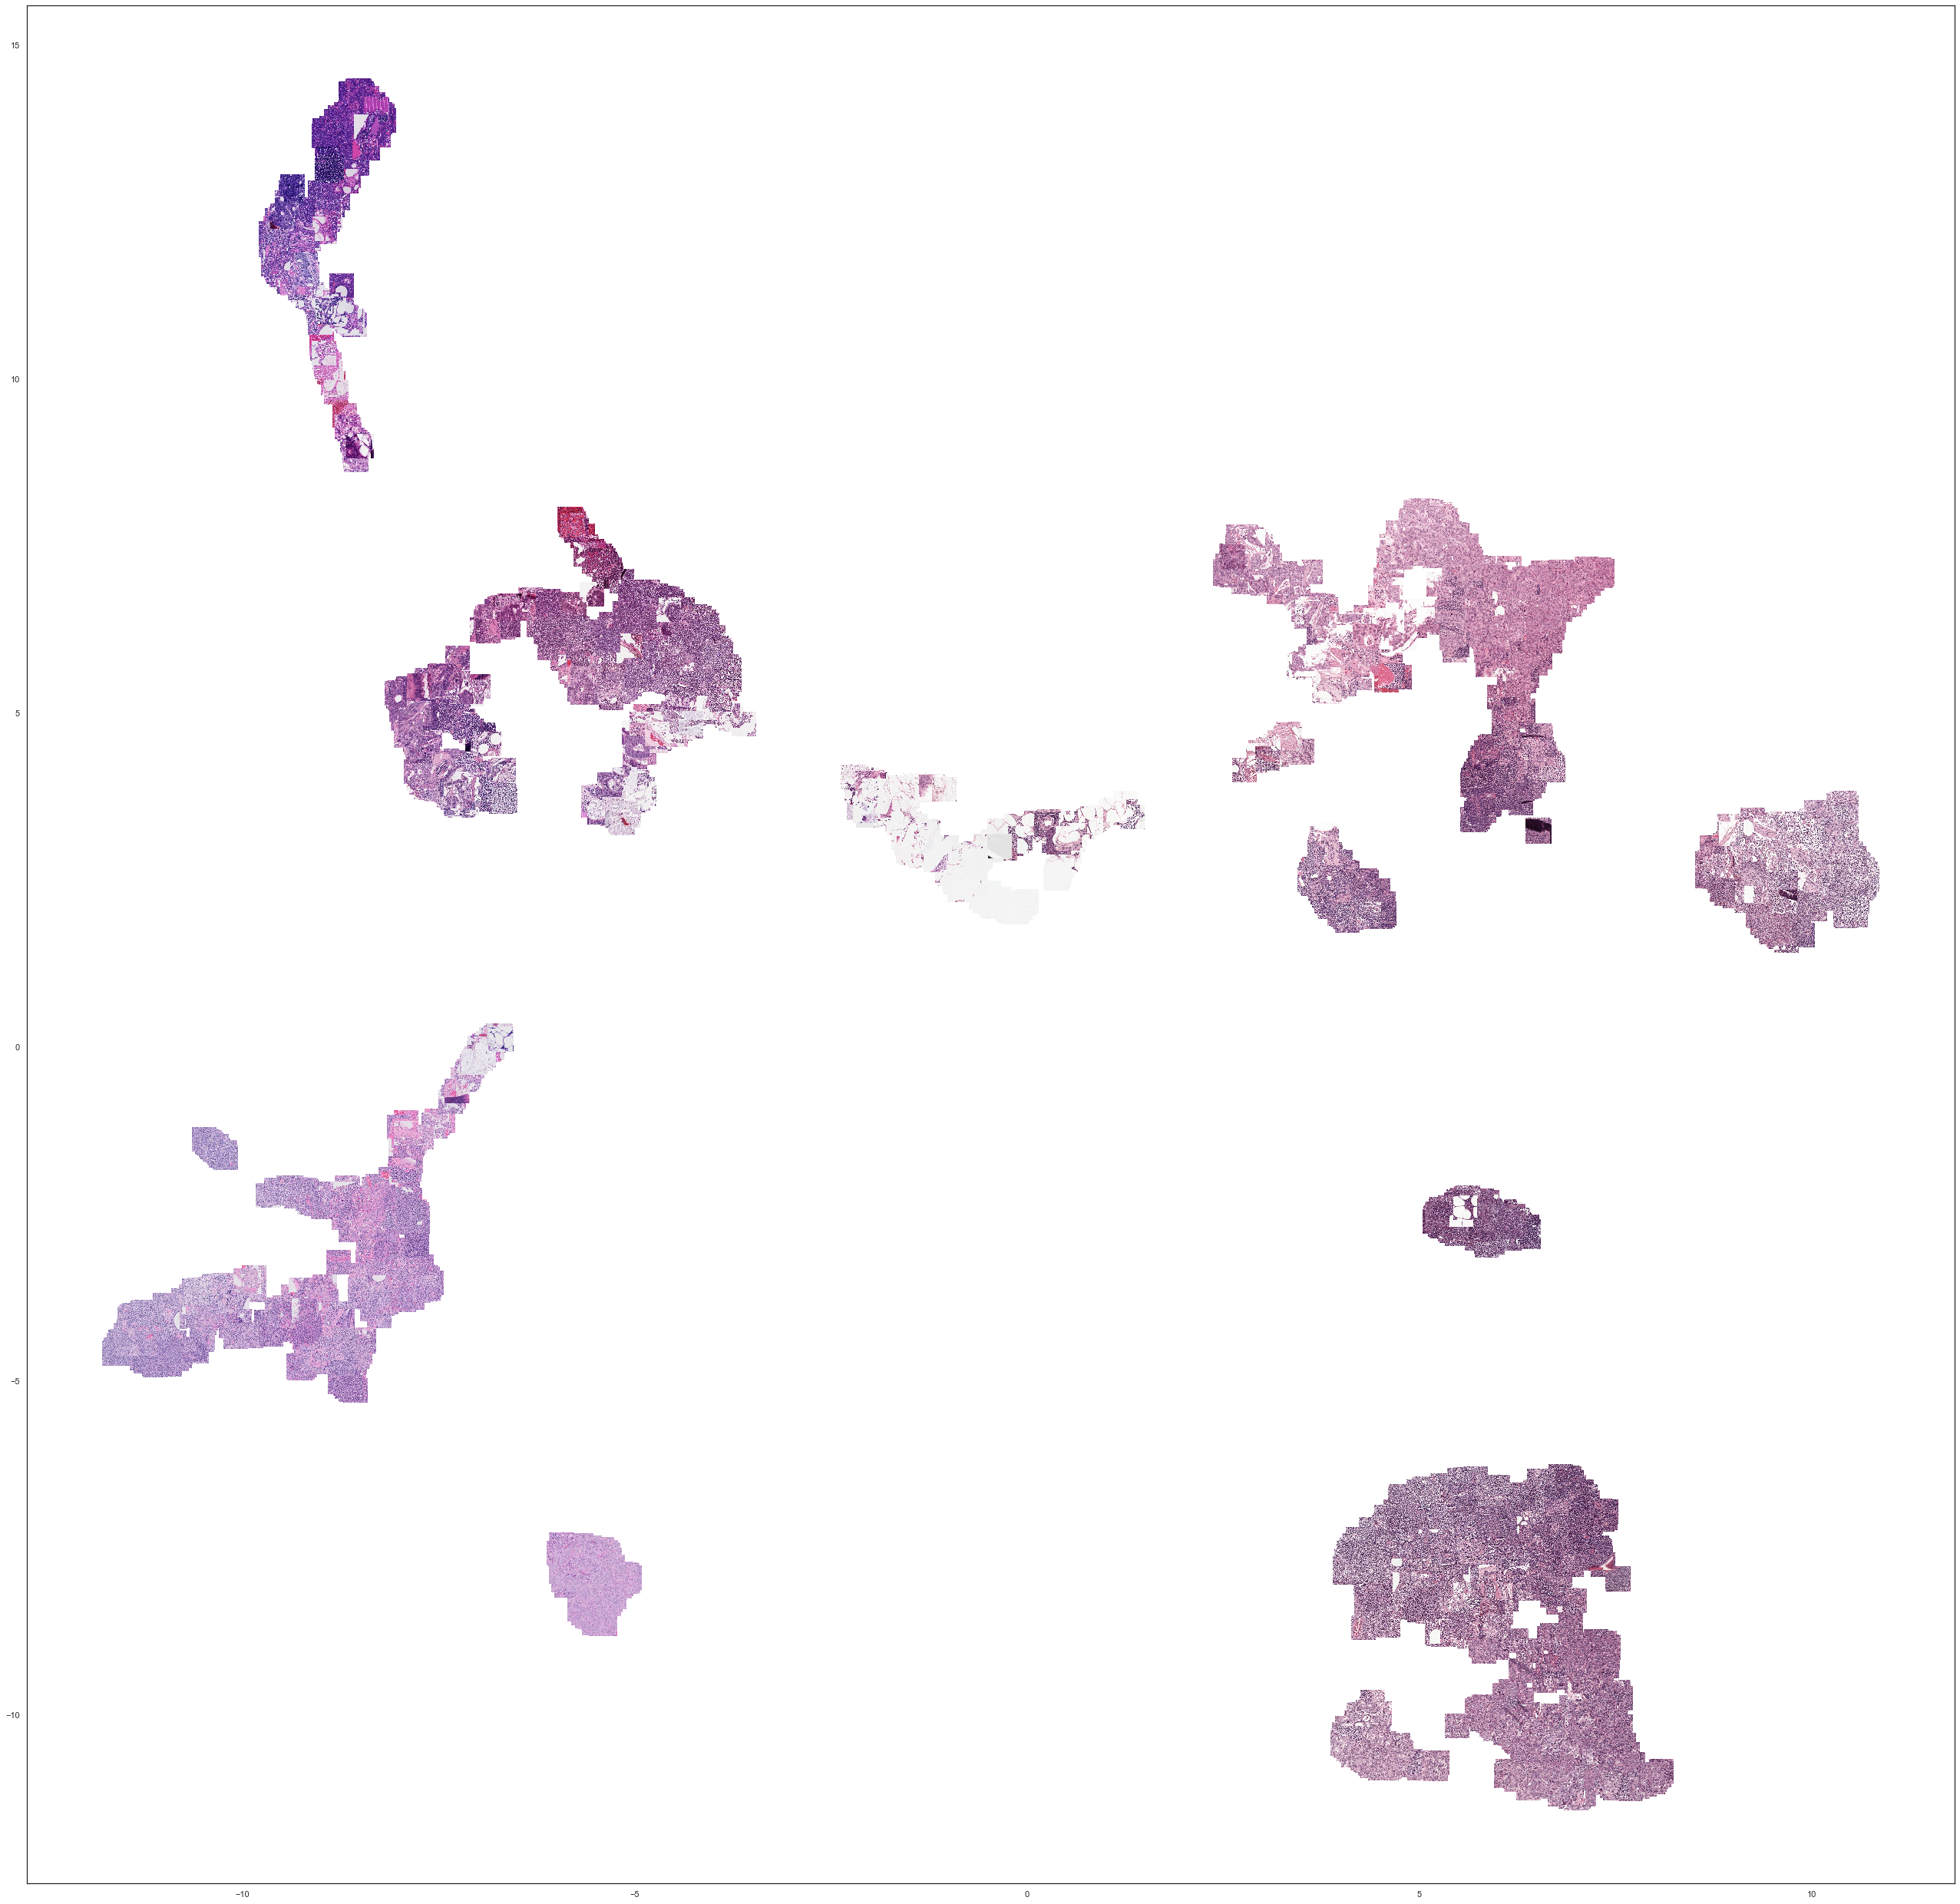

In [104]:
visualize_scatter_with_images(embedding, images_common, save=False)

# Prepare dataset

In [35]:
camelyon_dataset = pd.read_csv('E:/data/camelyon_tumor_20x/camelyon17_patches.csv')

e:\.venvs\greedy_infomax-eqyl1qxu\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
camelyon_dataset['request_id'] = camelyon_dataset['slide_id']

In [37]:
def get_filename(patch_id):
    return f'camelyon17_imagedata/{patch_id}.jpg'

In [38]:
camelyon_dataset['filename'] = camelyon_dataset.patch_id.apply(get_filename)

In [40]:
camelyon_dataset=camelyon_dataset.set_index('patch_id')

In [65]:
camelyon_cleaned = get_dataloader.clean_data('E:/data/camelyon_tumor_20x', camelyon_dataset)

Removing non-existing file from dataset: 85f697bba7f8a3b9ac71bf39d767ea0ae67c986227d106c4210cd8ecc36dffe8.jpg
Removing non-existing file from dataset: 9480de90f424fbd46cb764be9957702cfaba6e5008f95f6a9d4a399173cb571d.jpg


In [66]:
camelyon_cleaned = camelyon_cleaned.drop('8ffe7ba5f4db7cfd5b508d592e9db9f9862516f5f5623dcd128abe4d655cfe5d')

In [67]:
def cam_label_to_int(label):
    if label == 'TUMOR': return 1
    if label == 'NONTUMOR': return 0
    raise NotImplementedError()

In [68]:
camelyon_cleaned['label_int'] = camelyon_cleaned.label.apply(cam_label_to_int)

In [57]:
colon_dataset = pd.read_csv('E:/data/colon/exp_1911apka/colon_patches.csv')

e:\.venvs\greedy_infomax-eqyl1qxu\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
def add_to_filename(filename):
    return f'colon_imagedata/{filename}'

In [59]:
colon_dataset['filename'] = colon_dataset.filename.apply(add_to_filename) 

In [60]:
colon_cleaned = get_dataloader.clean_colon_data('E:/data/colon/exp_1911apka', colon_dataset)

Removing non-existing file from dataset: colon_imagedata/roi_lgl_norm/8310.jpgTotal number of images dropped:  40


In [71]:
def lnco_label_to_int(label):
    if label == 'tumor': return 1
    if label == 'roi_lgl_norm': return 0
    raise NotImplementedError()

In [72]:
colon_cleaned['label_int'] = colon_cleaned.label.apply(lnco_label_to_int)

In [94]:
df_common = colon_cleaned.append(camelyon_cleaned, sort=False)

In [95]:
df_common.to_csv('lnco_camelyon_patches.csv', index=False)